### 1. 패키지 import 및 파이토치 버전 확인

In [19]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models, transforms

# 파이토치 버전 확인
print('PyTorch Version: ', torch.__version__)
print('Torchvision Version: ', torchvision.__version__)

PyTorch Version:  2.5.1+cu124
Torchvision Version:  0.20.1+cu124


### 2. 학습된 VGG-16 모델 읽기

In [ ]:
# VGG-16 모델 인스턴스 생성
use_pretrained = True
net = models.vgg16(weights=models.VGG16_Weights.DEFAULT) # 최신 버전 변경사항
net.eval()

# 모델 네트워크 구성 출력
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 3. 입력 이미지의 전처리 클래스 작성

In [21]:
# 입력 이미지 전처리 class
class BaseTransform():
    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize), # 짧은 변의 길이를 size로 맞춤
            transforms.CenterCrop(resize), # 이미지 중앙 crop
            transforms.ToTensor(),
            transforms.Normalize(mean, std) # 색상 정보 표준화            
        ])
    
    def __call__(self, img):
        return self.base_transform(img)

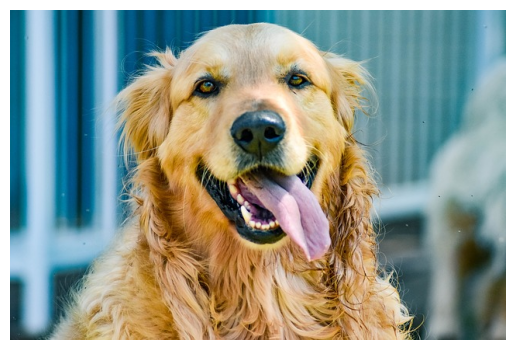

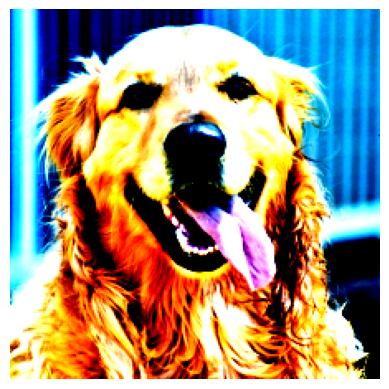

In [24]:
# 이미지 전처리 확인
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path) # [높이 x 너비 x 채널]

plt.imshow(img)
plt.axis('off')
plt.show()

resize = 224
mean = (0.484, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)

# (색, 높이, 너비) -> (높이, 너비, 색상) 변환 및 [0-1]로 값 제한
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)

plt.imshow(img_transformed)
plt.axis('off')
plt.show()

### 4. 출력 결과로 라벨을 예측하는 후처리 class 생성

In [26]:
# ILSVRC 라벨 정보를 읽어 사전형 변수 생성
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [35]:
class ILSVRCPredictor():
    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        maxid = np.argmax(out.detach().numpy())
        prediction_label_name = self.class_index[str(maxid)][1]
        
        return prediction_label_name

### 5. 학습된 VGG 모델로 이미지 예측

In [37]:
ILSRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))

predictor = ILSVRCPredictor(ILSVRC_class_index)

image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

transfrom = BaseTransform(resize, mean, std)
img_transformed = transform(img)
inputs = img_transformed.unsqueeze(0)

out = net(inputs)
result = predictor.predict_max(out)

print('입력 이미지의 예측 결과: ', result)

입력 이미지의 예측 결과:  golden_retriever
